# Evaluator Optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

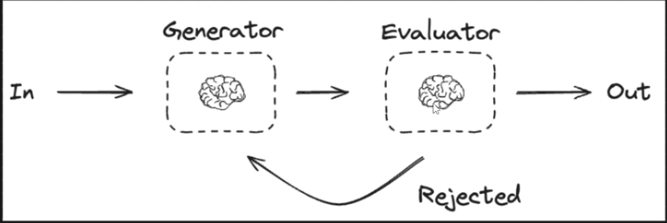

In [88]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict, Literal
from dotenv import load_dotenv
load_dotenv()

True

In [89]:
# state

class State(TypedDict):
    topic:str
    joke:str
    evaluation:str
    feedback:str

In [90]:
llm=ChatGroq(model='llama-3.1-8b-instant')

In [91]:
# schema for evaluaton
from pydantic import BaseModel,Field

class EvaluatorSchema(BaseModel):
    funny_or_not:Literal['funny','not_funny']=Field(description="Evaluate joke funny or not")
    feedback:str=Field(description="if joke is not funny provide a feedback")

In [92]:
llm_feedback=llm.with_structured_output(EvaluatorSchema)

In [93]:
def gen_joke(state:State)->State:
    if state.get('feedback'):
        prompt= f"generate a joke on the topic: {state['topic']} based on the feedback {state['feedback']}"
        res=llm.invoke(prompt)
    else:
        res=llm.invoke(f"Write a joke based on follwing topic : {state['topic']}")
    return {'joke':res.content}

In [94]:
def evaluator(state:State):
    prompt =f"Evaluate the joke as funny or not joke:{state['joke']} if joke is not funny provide a feedback also"
    res=llm_feedback.invoke(prompt)
    return {'evaluation':res.funny_or_not,
    'feedback':res.feedback}

In [95]:
# routing
def route(state:State):
    if state['evaluation']=='funny':
        return 'Accepted'
    else:
        return 'Not Accepted'

In [96]:
# graph

graph=StateGraph(State)
graph.add_node('gen_joke',gen_joke)
graph.add_node('evaluation',evaluator)

graph.add_edge(START,'gen_joke')
graph.add_edge('gen_joke','evaluation')
graph.add_conditional_edges(
    'evaluation',route,{
        'Accepted':END,'Not Accepted':'gen_joke'
    }
)
graph.add_edge('gen_joke',END)
workflow=graph.compile()

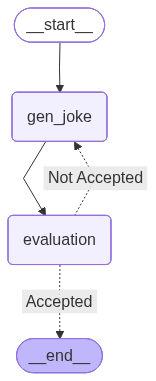

In [97]:
workflow

In [98]:
workflow.invoke(
    {'topic':'Ai Agent'}
)

{'topic': 'Ai Agent',
 'joke': 'Why did the AI agent go to therapy?\n\nBecause it had a glitch in its personality and was struggling to process its emotions.',
 'evaluation': 'funny',
 'feedback': 'It is a pun on the AI having a glitch in its personality and struggling to process emotions which is a funny spin on how AI typically struggles with emotions, it is well crafted and likely to make the audience laugh.'}